In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import xarray as xr
import pickle
import datetime
print('finished...')

finished...


length of 0TKE: 4320


Text(0, 0.5, 'Power [MW]')

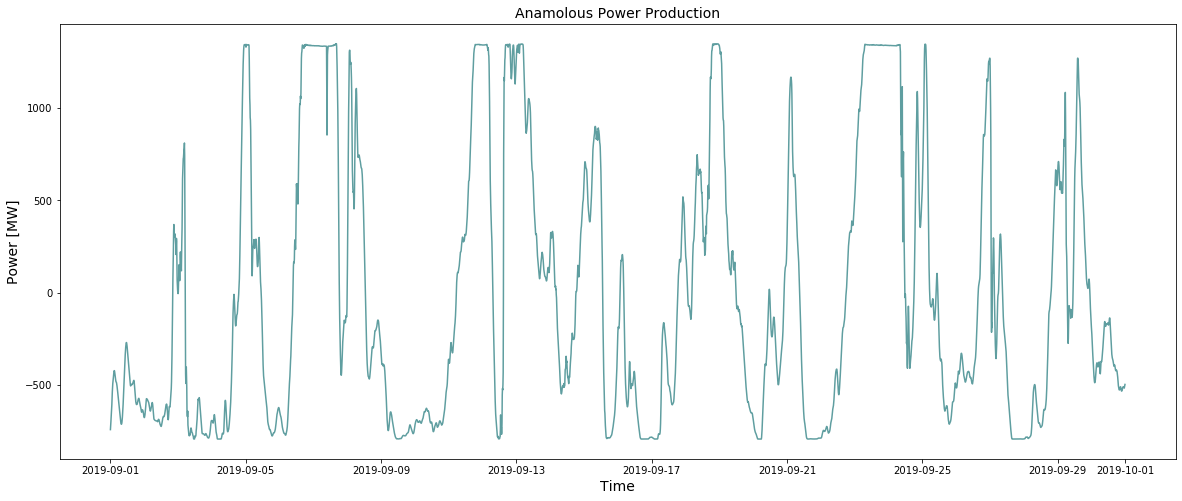

In [156]:
# This data comes from September so create times for a plot
delta = datetime.timedelta(minutes=10)
daterange = np.array([datetime.datetime(2019,9,1,0,0), datetime.datetime(2020,8,31,23,50)])
all_times = np.array([])
current_time = daterange[0]
while current_time <= daterange[-1]:
    all_times = np.append(all_times, current_time)
    current_time += delta
# get indices for September so they can be written to a file 
Sep = np.where((all_times >= datetime.datetime(2019,9,1,0,0)) & (all_times <= datetime.datetime(2019,9,30,23,50)))

# Read in power data
directory = '/pl/active/WRFLES_GAD/N_Atl/reruns_Beiter/small_files/vw_0tke/2019/09/'
file1 = open(directory+'power_0tke.txt','r')
contents_split = file1.read().splitlines()
contents_split = np.array(contents_split)
power_0tke_new = contents_split.astype(np.float)/1e6

print('length of 0TKE:', len(power_0tke_new))
data = power_0tke_new - np.mean(power_0tke_new)
anom = data

# Plot 
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(all_times[Sep[0]],data, c='cadetblue')
ax.set_title('Anamolous Power Production', fontsize=fs)
ax.set_xlabel('Time', fontsize=fs)
ax.set_ylabel('Power [MW]', fontsize=fs)

In [157]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.95 ## set statistical significance level

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])

### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print('lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))


def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow = 2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function
## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
## For the homework we just multiply by 1
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1.,red_fit_n)  

#-----------
window_length = 100
## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 59, factor fw=?, using more of the data so not multiplying by 1.2
print('DOF =',dof_welch)
print()
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance;

lag-1 autocorrelation = 1.0 and Te = 653.0
51
DOF = 86.4



frequency with stat. sig. power: 0.01
Power at that frequency: 0.6092931263689275
The cycle is: 1000.0 minutes


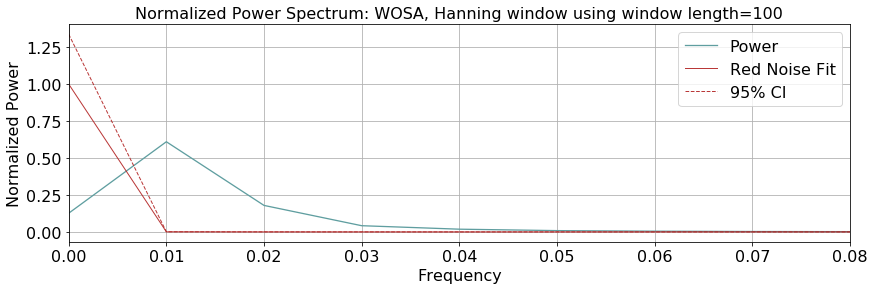

In [158]:
### Calculate the power spectrum of the original data

## Use the Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
freq_w = np.arange(0.,(window_length/2)+1.)/window_length
P_welch = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## plot
fs = 16
fig,ax = plt.subplots(1,1,figsize=(14,4))
plt.grid()
ax.set_xlabel('Frequency', fontsize=fs)
ax.set_ylabel('Normalized Power', fontsize=fs)
#ax.set_ylim(0.0,0.20)
ax.set_xlim(0.0,0.08)  
ax.plot(freq_w,P_welch_n, color='cadetblue', lw=1.3, label='Power');
ax.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit');
ax.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
ax.set_title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=fs);
ax.tick_params(labelsize=fs)
plt.legend(fontsize=fs)

flag = np.where(P_welch_n > f_bounds_welch)[0]
print('frequency with stat. sig. power:', freq_w[flag[0]])
print('Power at that frequency:', P_welch_n[flag[0]])
print('The cycle is:', 1/freq_w[flag[0]]*10, 'minutes')



frequency_cutoff: 0.16666666666666666
frequency_cutoff_in_mins: 60.0


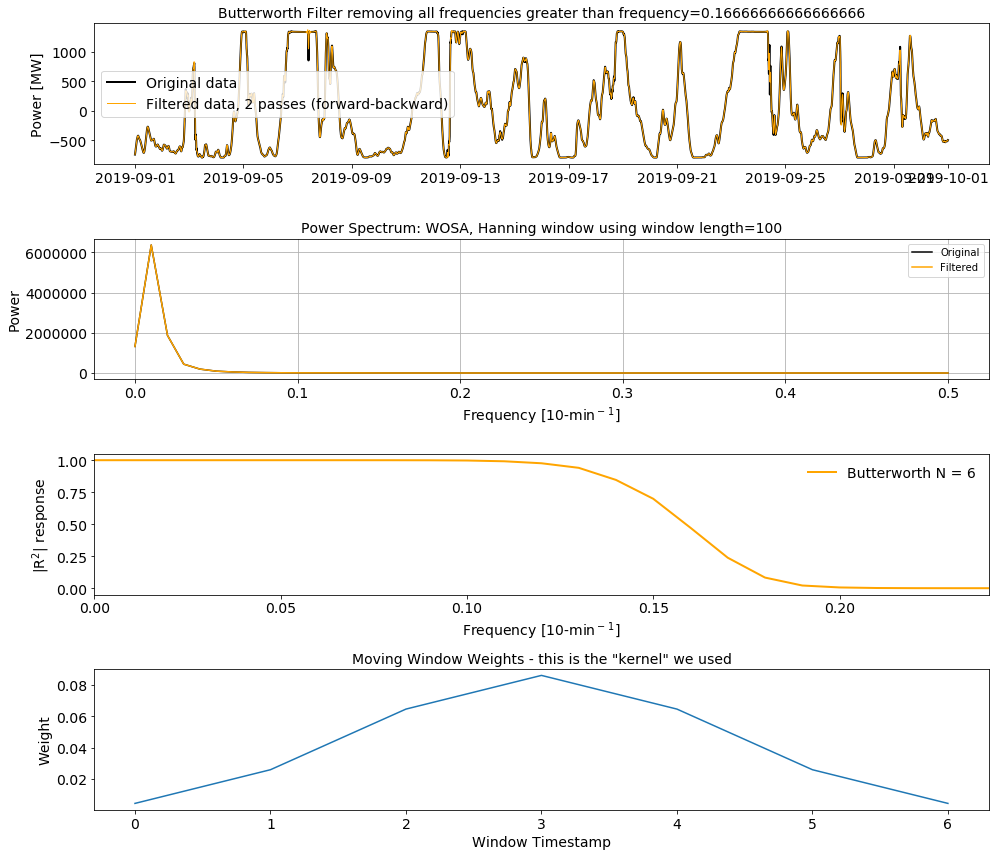

In [159]:
## Butterworth filtering


frequency_cutoff = 1/6  # remove frequencies greater than this cutoff
frequency_cutoff_in_mins = 1/(frequency_cutoff)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_mins: "+str(frequency_cutoff_in_mins*10))

### Apply a Butterworth filter (recursive filter) to the data
N = 6 ## number of weights
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,data) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
#P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]


## plot
fs = 14
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(all_times[Sep[0]],anom,'-k',linewidth = 2, label = 'Original data', zorder=1);
plt.plot(all_times[Sep[0]],y,'orange',linewidth = 1, label = 'Filtered data, 2 passes (forward-backward)', zorder=2);
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=fs)
plt.ylabel('Power [MW]', fontsize=fs)
plt.legend(fontsize = 14)
plt.tick_params(labelsize=fs)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency [10-min$^-$$^1$]', fontsize=fs)
plt.ylabel('Power', fontsize=fs)
#plt.ylim(0.0,0.40)
#plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'orange',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=fs);
plt.tick_params(labelsize=fs)

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'orange',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency [10-min$^-$$^1$]',fontsize=fs);
plt.ylabel('|R$^2$| response',fontsize=fs);
plt.legend(fontsize=fs, frameon = False);
#plt.ylim(0.0,1.0);
plt.xlim(0.0,0.24); 
plt.tick_params(labelsize=fs)

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used', fontsize=fs)
plt.xlabel('Window Timestamp', fontsize=fs)
plt.ylabel('Weight', fontsize=fs)
plt.tick_params(labelsize=fs)
f.tight_layout()



In [160]:
print('autocorrelations:')
lag1_r,lag1_p = stats.pearsonr(anom[0:len(anom)-1],anom[1:len(anom)])
print('original:', lag1_r)

lag1_r,lag1_p = stats.pearsonr(y[0:len(y)-1],y[1:len(y)])
print('filtered:', lag1_r)

autocorrelations:
original: 0.9984695131569973
filtered: 0.9987755122014376
